# Lab2: Simple Recurrent Network Models for Experimental Predictions
#### Jennifer Spenader, Inga Lang, Joost Warmerdam, Mi Tang, 2021

## Learning Goals for this lab:

* Extend practical skills in using Python and Keras to implement simple recurrent networks
* Understand the motivations for the second simulation study in the Mirman, Graf Estes and Magnuson (2010) paper
* Implement the simulation architecture and run the simulation
* Extend knowledge by further building a simulation for the Misyak, Christiansen and Tomblin (2009) study
* Confirm the findings of the two papers by performing a new single reaction experiment with new data
* Reflect on whether you think the model predictions are realisting enough for human participants or not

**Note:** only questions next to capital letters in `Exercise` sections need to be included in the report. Other questions are rhetorical.

# Part 1: Recreating Mirman et al.

Let's first focus on these second model in the Mirman, Graf Estes and Magnuson paper. To really understand this you should carefully read the paper, in particular page 4 and pages 9-11. First, make sure you understand what the model is trying to show. Answer the following questions:

## Exercise 1

 A) The Mirman et al. paper wants to find evidence linking statistical learning with word learning. In your own words, summarize briefly (but using precise terms) what results with human subjects (adults and children) are the trying to explain better?
 
ANSWER <br>
Previous studies have shown that statistical learning has an effect or influence on word learning. The objetive of these simulations is to investigate the importance of word frequency versus transitional probabily information on word learning

 B) What does Simulation 2 actually show?
    
ANSWER <br>
The second simulation investigates the connection between statistical word segmentation and word learning. It provided an insight into a link between statistical learning and referential word learning. It evaluated whether the way SRN learns transitional probabilities affects learning of words, partwords and non-word labels. 

The results show that after a brief initial period, the error for word labels was clearly lower than the error for partword labels. Novel-syllable nonword labels were learned more slowly than word, partword or novel-sequence nonword labels.    

 C) Explain briefly in what way do the results of Simulation 2 add to or clarify the human results.
 
ANSWER

In the Simulation 2 it compliments the human results in following ways:<br>

- The model results also provides a formal account that syllable involved in higher tranisitional probability sequences have more distinct phonological representation because of which infant and adults are better at learning labels with high transitional probability.<br>

- The model clearly demonstrates the advantage of word learning over partial words observed in human behavioural outcomes. The word labels errors rate was clearly low than partword labels as it was better at mapping input sequences to the unique objects when the sequences had high probabilities in the exposure phase compared to when they have low probabilities.<br>
  
- Simulation 2 also tested two types of nonwords. The findings add that nonword of the novel-syallable type were learned more slowly than words, partwords or unidentifiable words of the novel-sequence type.
  
  

 

## Model and data files

All the simulation data files can be found on Nestor under a folder named `Mirman_Sim`. (These are the ACTUAL files that the authors used for their paper implementation in Lens!). However, since the purpose of this lab is for you to recreate their simulation in Python, we have provided you with the necessary utilities for parsing the origina data. Just for reference, here are some of the key files with descriptions of their contents:
* `exposureSet2Syll35.ex`: Training examples for the exposure phase 
* `labelSet2SyllW35.ex`: Set of 'Words' for the label learning phase
* `labelSet2SyllPW35.ex`: Set of 'Part Words' for the label learning phase
* `labelSet2SyllNW35.ex`: Set of 'Non-Words'
* `labelSet2SyllNWc35.ex` : Another set of 'Non-Words'

Let's first import all of our necessary utilities for this lab: The `tensorflow.keras` modules for implementing and training our SRNs, some generic Python modules as well as the aforementioned lab utilities from the `mirman_utils.py` script that you can also find in Nestor under `Lab2`. The `LensParser` class takes care of parsing the input data from the Lens format to Python lists and the `Binarizer` class transforms these data to binary `numpy` vectors for interfacing with `keras`.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TimeDistributed, Flatten
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import SGD

import random
import numpy as np 

from matplotlib import pyplot as plt 

In [2]:
from mirman_utils import LensParser, Binarizer, multi_plot

The Mirman simulation consists of two phases. First, in the *exposure phase*, the model is presented with 1000-syllable sequences. Our recurrent network takes as an input the first syllable (encoded as a one-hot vector representation) and predicts the next syllable (again encoded as a one-hot vector). The second syllable of the word is then the second input and the third syllable is predicted, etc. Does this model look similar to you as the one that Elman used for lexical class learning? In what ways? The purpose of this phase is to simulate the exposure of human subjects to statistical dependencies between syllables of words in an artificial language.

After the exposure phase, the model is trained on a *label learning* task. The purpose is for our model to activate one out of 5 unique "object" labels after presented with a two-syllable word. This phase simulates the potential of human subjects in learning to map new words to their object representations in the world. Four different label categories, including different overlapping syllable dependencies with the exposure phase are included in order to further research the connection between this statistical learning and word learning. In other words, the research question at hand is whether an SRN that is trained to predict labels for words consisting of syllable transitions never encountered before (or encountered with smaller probabilities) follows the same behaviour in learning them as human subjects do.


After reading the paper fill the code below to define the Mirman SRN model.

**Note:** Even though in the paper implementation it is explicitely said that the output consists of 15 neurons (the first 10 are for what and the second 5 for what?) in order to follow the traditional `keras` flow and keep things simple we need to define our model's output as 20, the same as the input, even though our model will learn never to activate the last 5.

In [3]:
## fillin _ with the correct parameter 
model = Sequential([
    SimpleRNN(8, input_shape=(None, 20),
              return_sequences=True,
              activation='tanh',
              name='hidden'),
    TimeDistributed(Dense(20, activation='softmax', name='output'))
])

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(learning_rate=0.05, momentum=0.9),
              metrics=['categorical_accuracy', 'mean_squared_error'])


2022-05-23 10:29:26.889363: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None


## Exercise 2
 
 A) Take a look at the provided Lens file for the exposure phase data. In the Lens format, the syllables are abstract sequences of node activations, with an integer representing the bit of the one-hot encoding that is activated, with each set of two input-output ('I' and 'T') pairs treated as a single 2-syllable word, e.g:
   
    name: {1_0} 2
    I: {  1} 3
    T: {  1} 7 
    I: {  1} 7 
    T: {  1} 1
    ;
   
In this example, the current word consists of the $[3,7]$ syllables (out of the 10 used for exposure phase) and the first syllable of the next word is $1$. There are $1000$ such examples of syllable transitions in this file. Explain how this number is arrived at given the Lens format.







ANSWER <br>
There are 100 words with input syllables of range [3, 9] in them. The total number of input syllables of all ranges add upto 500, and since every input is followed by an output in the lens file, there are a total of 1000 syllables. The number of words and the number of syllables it contains is plotted below.

In [59]:
lensP = LensParser()
exposure_dat = lensP.parse_sequence('exposureSet2Syll35.ex')

In [58]:
wo = []
wc = []
coun = 0
for i in exposure_dat:
    if i != 1:
        coun+=1
    elif i == 1:
        wo.append((coun/2))
        coun = 1

wo.append(coun/2)
for i in range(10):
    wc.append(wo.count(i))

<BarContainer object of 10 artists>

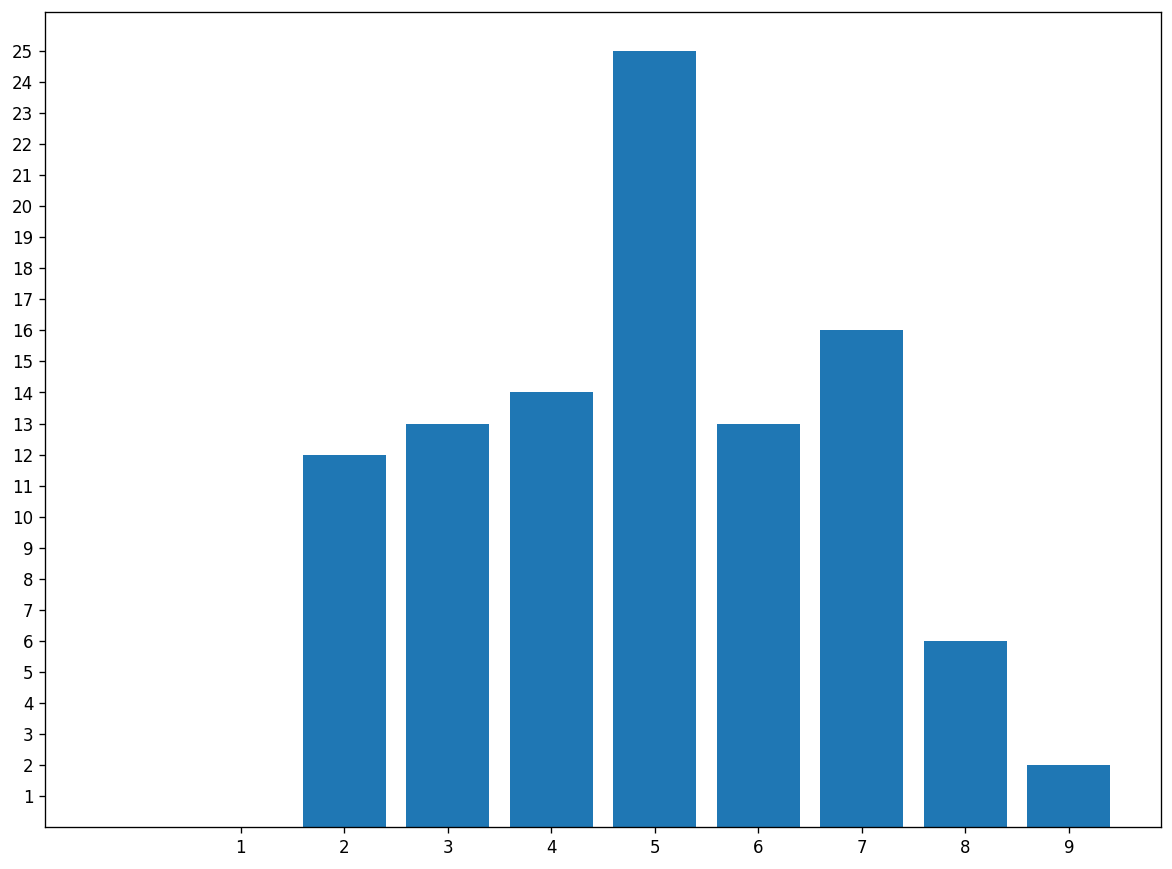

In [7]:
plt.figure(figsize=(12, 9), dpi=120)
plt.xticks(range(1,11))
plt.yticks(range(1,26))
plt.bar(range(10), wc)

 B) Do the same for the provided label learning data files. In each such file, the same format is used, but for defining the 5 different two-syllable words that the network must learn to distinguish. These are just the description of the labels and not the training data themselves. For example in the word data file:
 
     name: {4} 2
     I: {  1} 4 
     T: {  1} 13
     I: {  1} 9 
     T: {  1} 13
     ;
     
This block tells us that the 2-syllable word $[4,9]$ should be mapped to label $13$. Give the set of all different labels in all such files. What does this set have to do with our network's output activations? 

ANSWER<br>
For each of the labels, there are 5 syllable pairs, which describe which output is activated when one of the inputs is given. It can be observed that some input-output pairs clash and this difference of output for the same input is crucial as it helps the model differentiate between the word labels, and helps in having correct output activations.


In [60]:
files_labels = ['W', 'PW', 'NW', 'NWc']

for label in files_labels:
    print(label + 'ords')
    all_labels = lp.parse_sequence('labelSet2Syll' + label + '35.ex')
    for j in range(len(all_labels)-1):
        if j % 2 == 0:
            print(str(all_labels[j]) + ' --> ' + str(all_labels[j+1]))

Words
1 --> 2
8 --> 5
6 --> 0
4 --> 9
3 --> 7
PWords
2 --> 8
5 --> 6
0 --> 4
9 --> 3
7 --> 1
NWords
1 --> 2
8 --> 5
6 --> 0
4 --> 9
3 --> 7
NWcords
1 --> 8
2 --> 5
6 --> 4
0 --> 9
7 --> 3


C) Out of the two non-word data files, one contains novel-sequence non-words (syllable transitions never encountered in the exposure phase) and one novel-syllable non-words (new syllables). Which one is which? How can you tell?

ANSWER<BR>
The two non word data files conatins two different types of novel non words. After obvserving the given data files, it can be conculded that the file with name 'NWc35' contains novel-sequences nonwords which are syllable transition never encountered in the exposure phase. This is due to the fact that the file is composed of syllable transitions or in novel pairings.

    name: {2} 2
    I:  {   1} 2
    T:  {   1} 11
    I:  {   1} 5
    T:  {   1} 11
    ;



The given example is taked from the file, it can be observed that model was never exposed to such syllbale transition from 2 to 11 in the expose phase. The model is exposed to different syllable transition  but never in this condition. Therefore, this gives rise to new syllable transitions making it a novel sequence non words.

On the other hand, the file 'NW35' contains novel syllables. For example:

    name: {2} 2
    I:  {   1} 18
    T:  {   1} 11
    I:  {   1} 15
    T:  {   1} 11
    ;

The above sample is completely new to the model and contains words with syllables that model has never seen. The model is trained on 10 syllables out of 20 and these non words contain syllable that the model was not exposed to making it novel- syllable non words(new syllables).

## Exposure Phase

Now that you've understood how our data is structured, let's implement the exposure phase of our simulation! First, use the `parse_sequence` method of the provided parser to parse the Lens files into Python lists. Inspect the data to verify you understand their structure compared to the Lens format. In order to convert our data to vector representations, we will define a `Binarizer` object and make use of the `binarize_sequence` method. Inspect the data shape and contents.

In [61]:
parser = LensParser()
bnzer = Binarizer(vocab_size=20)

exposure_data = parser.parse_sequence('exposureSet2Syll35.ex')

# inspect the first 10 tokens of the sequence
print(exposure_data[:10])

X_exposure, y_exposure = bnzer.binarize_sequence(exposure_data)

# inspect one-hot representations. Everything looks fine?
print(X_exposure.shape, y_exposure.shape)
print('-' * 48)
print(X_exposure[:,:10])
print('-' * 48)
print(y_exposure[:,:10])

[6, 0, 3, 7, 1, 2, 4, 9, 8, 5]
(1, 1000, 20) (1, 1000, 20)
------------------------------------------------
[[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]]
------------------------------------------------
[[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 

Now that our model and data are in place, you are ready to simulate the exposure phase!
(**Note:** When attempting to re-train your model remember to run the model definition cell again in order to re-initialize it, otherwise you are training on top of your previous weights!)

In [62]:
acc2, loss2, mse2 = [], [], []

for i in range(10):
    model2 = Sequential([
        SimpleRNN(8, input_shape = (None, 20),
                  return_sequences = True,
                  activation = 'tanh',
                  name = 'hidden'),
        TimeDistributed(Dense(20, activation = 'softmax', name = 'output'))
    ])

    model2.compile(loss = 'categorical_crossentropy', 
                  optimizer = SGD(learning_rate = 0.05, momentum = 0.9),
                  metrics = ['categorical_accuracy', 'mean_squared_error'])

    exposure_phase2 = model2.fit(X_exposure, y_exposure, epochs= 75, verbose=0)
    acc2.append(exposure_phase2.history['categorical_accuracy'][-1])
    loss2.append(exposure_phase2.history['loss'][-1])
    mse2.append(exposure_phase2.history['mean_squared_error'][-1])

print('Summary of each model:', model2.summary())
print('Average accuracy over 10 runs: ' + str(np.mean(acc2)))
print('Average loss over 10 runs: ' + str(np.mean(loss2)))
print('Average MSE over 10 runs: ' + str(np.mean(mse2)))

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed_100 (TimeD  (None, None, 20)         180       
 istributed)                                                     
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
Summary of each model: None
Average accuracy over 10 runs: 0.6375
Average loss over 10 runs: 1.0323200345039367
Average MSE over 10 runs: 0.024337045289576052


In [11]:
acc3, loss3, mse3 = [], [], []

for i in range(10):
    model3 = Sequential([
        SimpleRNN(8, input_shape = (None, 20),
                  return_sequences = True,
                  activation = 'tanh',
                  name = 'hidden'),
        TimeDistributed(Dense(20, activation = 'softmax', name = 'output'))
    ])

    model3.compile(loss = 'categorical_crossentropy', 
                  optimizer = SGD(learning_rate = 0.05, momentum = 0.9),
                  metrics = ['categorical_accuracy', 'mean_squared_error'])

    exposure_phase3 = model3.fit(X_exposure, y_exposure, epochs= 200, verbose=0)
    acc3.append(exposure_phase3.history['categorical_accuracy'][-1])
    loss3.append(exposure_phase3.history['loss'][-1])
    mse3.append(exposure_phase3.history['mean_squared_error'][-1])

print('Summary of each model:', model3.summary())
print('Average accuracy over 10 runs: ' + str(np.mean(acc3)))
print('Average loss over 10 runs: ' + str(np.mean(loss3)))
print('Average MSE over 10 runs: ' + str(np.mean(mse3)))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed_20 (TimeDi  (None, None, 20)         180       
 stributed)                                                      
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
Summary of each model: None
Average accuracy over 10 runs: 0.669899994134903
Average loss over 10 runs: 0.7495551347732544
Average MSE over 10 runs: 0.018598109297454358


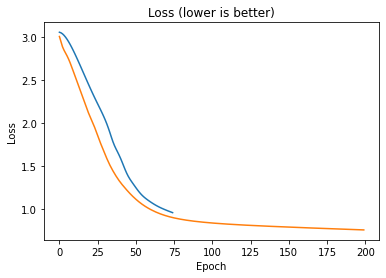

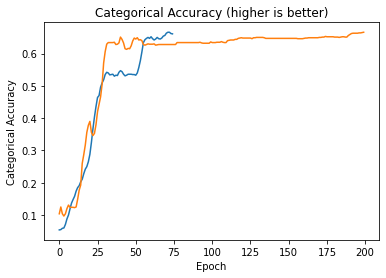

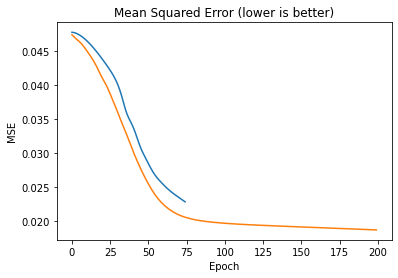

In [12]:
plt.plot(exposure_phase2.history['loss'])
plt.plot(exposure_phase3.history['loss'])
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(exposure_phase2.history['categorical_accuracy'])
plt.plot(exposure_phase3.history['categorical_accuracy'])
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(exposure_phase2.history['mean_squared_error'])
plt.plot(exposure_phase3.history['mean_squared_error'])
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

postexposure_weights = model2.get_weights()
postexposure_weights = model3.get_weights()

## Exercise 3

 A) Train multiple times and average your results. How much training is needed to get a low error rate? (include an example graph in your report)
 
ANSWER<br>
The model was trained multiple times to get a low error rate. Training was carried out for 75 epochs and the results obtained are shown above. 

The graphs of loss and mean squared error depicts that both the metrics decreases with each epoch and reaches nearly zero.

A model was separately trained for 200 epochs, and we can observe that the metrics improve very slowly from 100 epochs. There is not need of keep training the model after 100 epochs.

 B) How much training did they report in the paper? Would half this training be sufficient? Experiment and explain your results.
 
 ANSWER<br>
  In the paper, the model was reported to be trained for 75 epochs. The sufficiency of the model was evaluated with half of the training epochs reported in the paper. The results obtained after training the model for 37 epochs are shown below.
  
  According to the results, the loss and error achieved by the end of the training (37 epochs) was slightly high than obtained previously when trained for 75 epochs. The model accuracy was also below. In my opinion, the model was not properly trained to achieve high performance and half of the training mentioned in the paper is not sufficient.

In [63]:
acc5, loss5, mse5 = [], [], []

for i in range(10):
    model5 = Sequential([
        SimpleRNN(8, input_shape = (None, 20),
                  return_sequences = True,
                  activation = 'tanh',
                  name = 'hidden'),
        TimeDistributed(Dense(20, activation = 'softmax', name = 'output'))
    ])

    model5.compile(loss = 'categorical_crossentropy', 
                  optimizer = SGD(learning_rate = 0.05, momentum = 0.9),
                  metrics = ['categorical_accuracy', 'mean_squared_error'])

    exposure_phase5 = model5.fit(X_exposure, y_exposure, epochs= 37, verbose=0)
    acc5.append(exposure_phase5.history['categorical_accuracy'][-1])
    loss5.append(exposure_phase5.history['loss'][-1])
    mse5.append(exposure_phase5.history['mean_squared_error'][-1])

print('Summary of each model:', model5.summary())
print('Average accuracy over 10 runs: ' + str(np.mean(acc5)))
print('Average loss over 10 runs: ' + str(np.mean(loss5)))
print('Average MSE over 10 runs: ' + str(np.mean(mse5)))

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed_110 (TimeD  (None, None, 20)         180       
 istributed)                                                     
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
Summary of each model: None
Average accuracy over 10 runs: 0.5514999985694885
Average loss over 10 runs: 1.5367077231407165
Average MSE over 10 runs: 0.034981506317853926


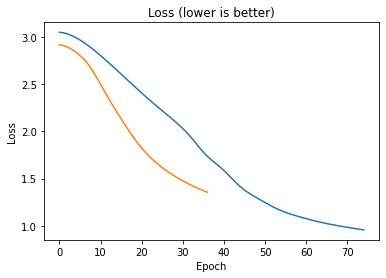

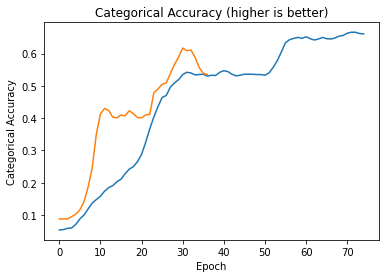

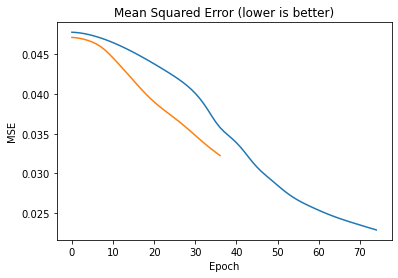

In [14]:
plt.plot(exposure_phase2.history['loss'])
plt.plot(exposure_phase5.history['loss'])
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(exposure_phase2.history['categorical_accuracy'])
plt.plot(exposure_phase5.history['categorical_accuracy'])
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(exposure_phase2.history['mean_squared_error'])
plt.plot(exposure_phase5.history['mean_squared_error'])
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

postexposure_weights = model2.get_weights()
postexposure_weights = model5.get_weights()

## Label Learning Phase

For the label learning phase, we will have to further train our model 4 times, once for every different category of label learning data (word, part-word, novel-syllable non-word and novel-sequence non-word). We will use the `parse_labels` method of our parser to obtain our 5 2-syllable label words. Inspect them to make sure you understand the data format. We then sample 100 examples from such words and binarize. Do our data shapes seem logical?

In [15]:
# load words label data for label learning phase
word_labels = parser.parse_labels('./labelSet2SyllW35.ex')

# inspect the data. Are they the same as in the input files?
print('Word labels={}'.format(word_labels))

# generate 100 training word examples
word_data = random.choices(word_labels, k=100)
print('First 5 word label examples={}'.format(word_data[:5]))

# convert to one-hot encodings
Xw, yw = bnzer.binarize_labels(word_data)

# inspect the input data shape. Make sense?
print('Word data shape={}, labels shape={}'.format(Xw.shape, yw.shape))

Word labels=[(1, 2, 10), (8, 5, 11), (6, 0, 12), (4, 9, 13), (3, 7, 14)]
First 5 word label examples=[(6, 0, 12), (1, 2, 10), (6, 0, 12), (6, 0, 12), (4, 9, 13)]
Word data shape=(1, 200, 20), labels shape=(1, 200, 20)


Without re-initializing our model (keeping the weights the same as after the exposure phase) we are ready to further train it for the label learning task!

In [18]:
word_labels = parser.parse_labels('labelSet2SyllW35.ex')
partword_labels = parser.parse_labels('labelSet2SyllPW35.ex')
nonword_labels1 = parser.parse_labels('labelSet2SyllNW35.ex')
nonword_labels2 = parser.parse_labels('labelSet2SyllNWc35.ex')

In [19]:
print('Word labels = {}'.format(word_labels))
print('PartWord labels = {}'.format(partword_labels))
print('NonWord labels = {}'.format(nonword_labels1))
print('NonWord labels = {}'.format(nonword_labels2))

Word labels = [(1, 2, 10), (8, 5, 11), (6, 0, 12), (4, 9, 13), (3, 7, 14)]
PartWord labels = [(2, 8, 10), (5, 6, 11), (0, 4, 12), (9, 3, 13), (7, 1, 14)]
NonWord labels = [(11, 12, 10), (18, 15, 11), (16, 10, 12), (14, 19, 13), (13, 17, 14)]
NonWord labels = [(1, 8, 10), (2, 5, 11), (6, 4, 12), (0, 9, 13), (7, 3, 14)]


In [20]:
word_data = random.choices(word_labels, k=100)
partword_data = random.choices(partword_labels, k=100)
nonword_data1 = random.choices(nonword_labels1, k=100)
nonword_data2 = random.choices(nonword_labels2, k=100)
print('\nFirst 5 word label examples = {}'.format(word_data[:5]))
print('First 5 partword label examples = {}'.format(partword_data[:5]))
print('First 5 nonword label examples = {}'.format(nonword_data1[:5]))
print('First 5 nonword label examples = {}'.format(nonword_data2[:5]))


First 5 word label examples = [(6, 0, 12), (8, 5, 11), (6, 0, 12), (4, 9, 13), (4, 9, 13)]
First 5 partword label examples = [(0, 4, 12), (2, 8, 10), (7, 1, 14), (9, 3, 13), (5, 6, 11)]
First 5 nonword label examples = [(14, 19, 13), (11, 12, 10), (18, 15, 11), (11, 12, 10), (16, 10, 12)]
First 5 nonword label examples = [(0, 9, 13), (1, 8, 10), (0, 9, 13), (0, 9, 13), (6, 4, 12)]


In [22]:
Xw, yw = bnzer.binarize_labels(word_data)
Xpw, ypw = bnzer.binarize_labels(partword_data)
Xnw1, ynw1 = bnzer.binarize_labels(nonword_data1)
Xnw2, ynw2 = bnzer.binarize_labels(nonword_data2)

print('\nWord data shape = {}, labels shape = {}'.format(Xw.shape, yw.shape))
print('PartWord data shape = {}, labels shape = {}'.format(Xpw.shape, ypw.shape))
print('NonWord data shape = {}, labels shape = {}'.format(Xnw1.shape, ynw1.shape))
print('NonWord data shape = {}, labels shape = {}'.format(Xnw2.shape, ynw2.shape))


Word data shape = (1, 200, 20), labels shape = (1, 200, 20)
PartWord data shape = (1, 200, 20), labels shape = (1, 200, 20)
NonWord data shape = (1, 200, 20), labels shape = (1, 200, 20)
NonWord data shape = (1, 200, 20), labels shape = (1, 200, 20)


In [23]:
model.set_weights(postexposure_weights)
words_learning = model.fit(Xw, yw, epochs=100, verbose=0)
model.set_weights(postexposure_weights)
partwords_learning = model.fit(Xpw, ypw, epochs=100, verbose=0)
model.set_weights(postexposure_weights)
nonwords_learning1 = model.fit(Xnw1, ynw1, epochs=100, verbose=0)
model.set_weights(postexposure_weights)
nonwords_learning2 = model.fit(Xnw2, ynw2, epochs=100, verbose=0)

Then, use the provided `multi_plot` function to compare the learning progress of the four different categories. (**Note:** You might want to take several trials of the four learning steps in order to gain serious insight about the results)

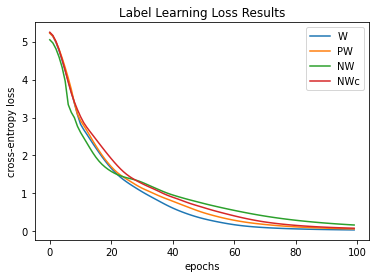

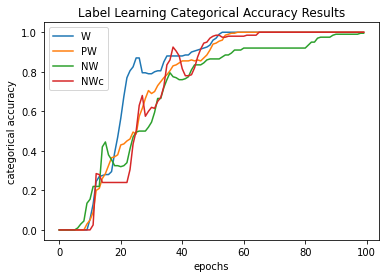

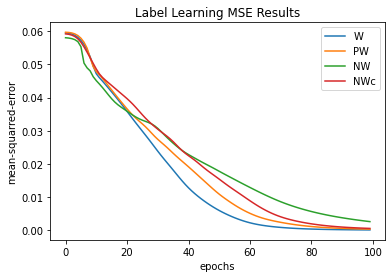

In [25]:
losses = [words_learning.history['loss'], partwords_learning.history['loss'], \
          nonwords_learning1.history['loss'], nonwords_learning2.history['loss']]

accuracies = [words_learning.history['categorical_accuracy'], \
              partwords_learning.history['categorical_accuracy'], \
              nonwords_learning1.history['categorical_accuracy'], \
              nonwords_learning2.history['categorical_accuracy']]


MSEs = [words_learning.history['mean_squared_error'], \
        partwords_learning.history['mean_squared_error'], \
        nonwords_learning1.history['mean_squared_error'], \
        nonwords_learning2.history['mean_squared_error']]


multi_plot(losses, accuracies, MSEs)

## Exercise 4


 

 


 A) Why do we need to include novel-syllable nonwords in the simulation? What purpose does it serve?
    
ANSWER    

The novel-syllable nonwords are included as necessary to study if the syllable familiarity had any effect on label learning.


 B) In the label learning phase, our model must be initialized with the postexposure weights. Explain why. 
 
 ANSWER
 
The same postexposure weights were used at the start of each label learning phase for maximum balance between the label learning conditions (for label learning phase for words, partwords, etc.)

 C) Report your comparison graph for the different label categories. Do you obtain similar results as those reported in the paper? Discuss any differences.
 
 ANSWER <br>
 
We can see that novel-syllable Nonwords were learned the fastest among all the labels.
 
 Partwords were learned faster than Words and Novel-sequence Nonwords but slower than Novel-syllable Nonwords.
 
 Words and Novel-sequence Nonwords were learned at almost similar and slowest pace of all the labels.

 D) Given the distincion between adult-child results in the human experiments and your model's results, would you say that your SRN model is simulating children or adults? Explain your answer.
 
 ANSWER
 
It was suggested in the second simulation that children exhibit better learning of Non-word labels than part-word labels and adults exhibit better learning of word labels than Non-word labels. 

From the graph above, it can be observed that the learning of Novel-syllable Nonwords was quicker than the learning of partwords, supporting the former suggestion. Therefore, the SRN model is simulating children, and not adults.

# Part 2: Modelling Misyak et al. (2010)
Read Misyak, Christiansen and Tomblin (2010). On page 139 you can find information about the human experiments and on page 145 the description of the SRN employed and the constructed training examples.

## Model and training data
Make sure you understand the experiment details, as you will have to create your own data for simulating it. The data in our case are strings consisting of 3 nonword tokens; A starting nonword syllable ($a$, $b$ or $c$), a middle bisyllabic nonword $X_1,...,X_{24}$ and an ending token ($d$, $e$ or $f$). What combinations are considered *grammatical* in the paper? The purpose of this simulation is to investigate whether the SRN model can learn to predict the ending token of each string after being exposed to the grammatical dependencies for several examples. 

In [27]:
import itertools

all_tokens = [
 'pel',
 'dak',
 'vot',
 'rid',
 'jic',
 'tood',
 'wadim',
 'kicey',
 'puser',
 'fengle',
 'coomo',
 'loga',
 'gople',
 'taspu',
 'hiftam',
 'deecha',
 'vamey',
 'skiger',
 'benez',
 'gensim',
 'feenam',
 'laelijeen',
 'chila',
 'roosa',
 'plizet',
 'balip',
 'malsig',
 'suleb',
 'nilbo',
 'wiffle'
]

start_tokens = all_tokens[:3]  ## {a,b,c}
end_tokens = all_tokens[3:6]   ## {d,e,f}
middle_tokens = all_tokens[6:] ## {X1,...,X24}

grammar_map = {
    'pel' : 'rid',   ## a->d
    'dak' : 'jic',   ## b->e
    'vot' : 'tood'   ## c->f
}

non_grammar_map = {
    'pel' : ['jic', 'tood'],
    'dak' : ['rid', 'tood'],
    'vot' : ['rid', 'jic']
}

As described in the paper, the simulation consists of three learning phases:
  * **Phase 1:** During this phase the model is presented with 6 grammatical blocks, each consisting of 72 *unique* strings containing all middle tokens. During this phase we expect the model to learn the inehrent dependencies present in our training exaxmples.
  * **Phase 2:** In the second phase the model is presented with 1 ungrammatical block containing 24 strings of all middle tokens with violated dependencies. This is meant to simulate the disruption in the predictive capacity of human subjects.
  * **Phase 3:** During this "recovery" phase, the model is presented again with 1 grammatical block like that of the first phase.  

The code below will provide you with all unique combinations of the $24$ middle tokens that hold the defined grammatic dependencies for each grammatical block: 

In [29]:
def generate_grammatical_block():
    return [(*r, grammar_map[r[0]]) for r in itertools.product(start_tokens, middle_tokens)]

# let's inspect a generated block. Does it look grammatical according to the paper? 
print(generate_grammatical_block())

[('pel', 'wadim', 'rid'), ('pel', 'kicey', 'rid'), ('pel', 'puser', 'rid'), ('pel', 'fengle', 'rid'), ('pel', 'coomo', 'rid'), ('pel', 'loga', 'rid'), ('pel', 'gople', 'rid'), ('pel', 'taspu', 'rid'), ('pel', 'hiftam', 'rid'), ('pel', 'deecha', 'rid'), ('pel', 'vamey', 'rid'), ('pel', 'skiger', 'rid'), ('pel', 'benez', 'rid'), ('pel', 'gensim', 'rid'), ('pel', 'feenam', 'rid'), ('pel', 'laelijeen', 'rid'), ('pel', 'chila', 'rid'), ('pel', 'roosa', 'rid'), ('pel', 'plizet', 'rid'), ('pel', 'balip', 'rid'), ('pel', 'malsig', 'rid'), ('pel', 'suleb', 'rid'), ('pel', 'nilbo', 'rid'), ('pel', 'wiffle', 'rid'), ('dak', 'wadim', 'jic'), ('dak', 'kicey', 'jic'), ('dak', 'puser', 'jic'), ('dak', 'fengle', 'jic'), ('dak', 'coomo', 'jic'), ('dak', 'loga', 'jic'), ('dak', 'gople', 'jic'), ('dak', 'taspu', 'jic'), ('dak', 'hiftam', 'jic'), ('dak', 'deecha', 'jic'), ('dak', 'vamey', 'jic'), ('dak', 'skiger', 'jic'), ('dak', 'benez', 'jic'), ('dak', 'gensim', 'jic'), ('dak', 'feenam', 'jic'), ('dak',

Fill the code snippet below to generate ungrammatical blocks of 24 strings for the second phase of our simulation. (***Hint:*** Dependencies now should like $aXe, aXf, bXd, bXf, cXd$ and $cXe$)

In [30]:
non_grammar_map = {
    'pel' : ['jic', 'tood'],
    'dak' : ['rid', 'tood'],
    'vot' : ['rid', 'jic']
}

def generate_ungrammatical_block(num_strings=24):
    list_1 = []
    j = 0
    for r in itertools.product(start_tokens, middle_tokens):
        if j == 0:
            temp = (*r, non_grammar_map[r[0]][0])
            j = 1
        elif j == 1:
            temp = (*r, non_grammar_map[r[0]][1])
            j = 0
        list_1.append(temp)
    ung_block = list_1[0:8] + list_1[32:40] + list_1[64:72]
    return ung_block

In [31]:
# inspect an ungrammatical block. 
print(generate_ungrammatical_block())

[('pel', 'wadim', 'jic'), ('pel', 'kicey', 'tood'), ('pel', 'puser', 'jic'), ('pel', 'fengle', 'tood'), ('pel', 'coomo', 'jic'), ('pel', 'loga', 'tood'), ('pel', 'gople', 'jic'), ('pel', 'taspu', 'tood'), ('dak', 'hiftam', 'rid'), ('dak', 'deecha', 'tood'), ('dak', 'vamey', 'rid'), ('dak', 'skiger', 'tood'), ('dak', 'benez', 'rid'), ('dak', 'gensim', 'tood'), ('dak', 'feenam', 'rid'), ('dak', 'laelijeen', 'tood'), ('vot', 'chila', 'rid'), ('vot', 'roosa', 'jic'), ('vot', 'plizet', 'rid'), ('vot', 'balip', 'jic'), ('vot', 'malsig', 'rid'), ('vot', 'suleb', 'jic'), ('vot', 'nilbo', 'rid'), ('vot', 'wiffle', 'jic')]


In [32]:
print(generate_ungrammatical_block())

[('pel', 'wadim', 'jic'), ('pel', 'kicey', 'tood'), ('pel', 'puser', 'jic'), ('pel', 'fengle', 'tood'), ('pel', 'coomo', 'jic'), ('pel', 'loga', 'tood'), ('pel', 'gople', 'jic'), ('pel', 'taspu', 'tood'), ('dak', 'hiftam', 'rid'), ('dak', 'deecha', 'tood'), ('dak', 'vamey', 'rid'), ('dak', 'skiger', 'tood'), ('dak', 'benez', 'rid'), ('dak', 'gensim', 'tood'), ('dak', 'feenam', 'rid'), ('dak', 'laelijeen', 'tood'), ('vot', 'chila', 'rid'), ('vot', 'roosa', 'jic'), ('vot', 'plizet', 'rid'), ('vot', 'balip', 'jic'), ('vot', 'malsig', 'rid'), ('vot', 'suleb', 'jic'), ('vot', 'nilbo', 'rid'), ('vot', 'wiffle', 'jic')]


In our simulation, as we are employing neural network models, all of our data need to be in continuous form. As a result, we will need to encode our vocabulary $\{a,b,c,d,e,f,X_1,...,X_{24}\}$ into vector representations. What is the size of our vocabulary? Then each nonword syllable or bisyllable should be mapped to a one-hot encoded vector of such size with a one in the index of the present syllable.

In [33]:
from sklearn.preprocessing import LabelBinarizer

In [34]:
# generate one grammatical block of 72 strings, one ungrammatical of default 24 strings
# and one "recovery" block of 72 grammatical strings
gram_block = random.sample(generate_grammatical_block(), 72)
ungr_block = random.sample(generate_ungrammatical_block(), 24)
rec_block = random.sample(generate_grammatical_block(), 72)

# define an one-hot encoder
encoder = LabelBinarizer()
encoder.fit(all_tokens)

# flatten the strings and transform all tokens to one-hot vectors
gram_tokens = [token for tokens in gram_block for token in tokens]
ungr_tokens = [token for tokens in ungr_block for token in tokens]
rec_tokens = [token for tokens in rec_block for token in tokens]

gram_vectors = encoder.transform(gram_tokens)
ungr_vectors = encoder.transform(ungr_tokens)
rec_vectors = encoder.transform(rec_tokens)

# define training data and targets by shifting the sequence one token to the left 
X_gram = gram_vectors[np.newaxis, :]
y_gram = np.append(gram_vectors[1:], gram_vectors[:1], axis=0)[np.newaxis, :]

X_ungr = ungr_vectors[np.newaxis, :]
y_ungr = np.append(ungr_vectors[1:], ungr_vectors[:1], axis=0)[np.newaxis, :]

X_rec = rec_vectors[np.newaxis, :]
y_rec = np.append(rec_vectors[1:], rec_vectors[:1], axis=0)[np.newaxis, :]

# what is the shape of our data? Does this match descriptions in the paper?
print(X_gram.shape, y_gram.shape, X_ungr.shape, y_ungr.shape, X_rec.shape, y_rec.shape)


(1, 216, 30) (1, 216, 30) (1, 72, 30) (1, 72, 30) (1, 216, 30) (1, 216, 30)


Right! Now to our model. By now, you should be experienced in defining SRNs. Read the description of the network parameters from the paper and fill the code below to define the simulation model. You might want to take a look at the Elman implementation from Lab 1 if unsure as to which should be the shape of input/output. 

In [35]:
## fillin _ with the correct parameter 
def Create_misyak_model():
    misyak_MODEL = Sequential([
        SimpleRNN(15, input_shape=(None, 30),
                  return_sequences= True,
                  activation='tanh',
                  recurrent_initializer= RandomUniform(minval = -1, maxval = 1),
                  name='hidden'),
        TimeDistributed(Dense(30, activation='softmax', name='output'))
    ])

    misyak_MODEL.compile(loss= 'categorical_crossentropy', 
                  optimizer=SGD(learning_rate = 0.1, momentum= 0.8),
                  metrics=['categorical_accuracy', 'mean_squared_error'])
    
    print(misyak_MODEL.summary())
    
    return misyak_MODEL

## Simulating the Three Learning Phases 
Run the three learning phases in order and plot your results. Instead of training our model a single epoch in each block, we scale it up to further smooth the learning process and provide better visualization insight.

In [36]:
scale_factor = 5
model_loss, model_acc, model_mse = [], [], []

for i in range(30):
    misyak_MODEL = Create_misyak_model()
    print('Model: ', i)
    print('-'*100)
    
    
    print('Phase 1: 6 grammatical blocks of 72 strings..\n')
    phase_1 = misyak_MODEL.fit(X_gram, y_gram, epochs=6*scale_factor, verbose=0)
    phase_1_loss = phase_1.history['loss']
    phase_1_acc = phase_1.history['categorical_accuracy']
    phase_1_mse = phase_1.history['mean_squared_error']
    print('-'*100)

    print('Phase 2: 1 ungrammatical block of 24 strings..\n') 
    phase_2 = misyak_MODEL.fit(X_ungr, y_ungr, epochs=1*scale_factor, verbose=0)
    phase_2_loss = phase_2.history['loss']
    phase_2_acc = phase_2.history['categorical_accuracy']
    phase_2_mse = phase_2.history['mean_squared_error']
    print('-'*100)

    print('Phase 3: 1 recovery block of 72 strings..\n')
    phase_3 = misyak_MODEL.fit(X_rec, y_rec, epochs=1*scale_factor, verbose=0)
    phase_3_loss = phase_3.history['loss']
    phase_3_acc = phase_3.history['categorical_accuracy']
    phase_3_mse = phase_3.history['mean_squared_error']
    print('-'*100)
    

    model_loss.append(phase_1_loss + phase_2_loss + phase_3_loss)
    model_acc.append(phase_1_acc + phase_2_acc + phase_3_acc)
    model_mse.append(phase_1_mse + phase_2_mse + phase_3_mse)
print(misyak_MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

--------------------------------------------------------------------------------------

                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                       

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 s

 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------

_________________________________________________________________
None
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                             

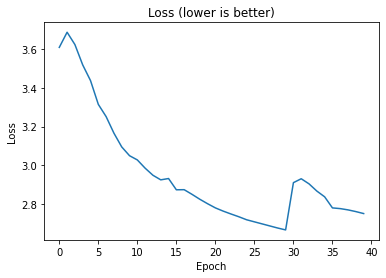

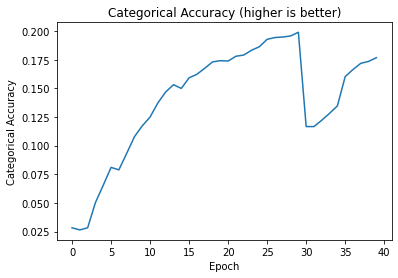

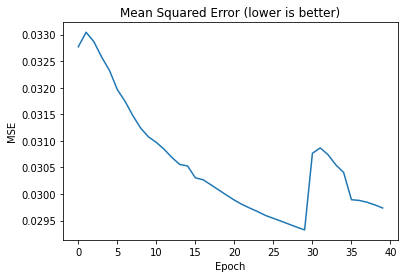

In [37]:
final_loss, final_acc, final_mse = [], [], []
for i in range(40):
    _loss, _acc, _mse = 0, 0, 0
    for j in range(30):
        _loss += model_loss[j][i]
        _acc += model_acc[j][i]
        _mse += model_mse[j][i]
    final_loss.append(_loss/30)
    final_acc.append(_acc/30)
    final_mse.append(_mse/30)

plt.plot(final_loss)
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(final_acc)
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(final_mse)
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

Make use of the `loss`, `categorical_accuracy` and `mean_squarred_error` keys of the the three phases history dictionaries (e.g. `phase_1.history` for phase 1) to plot the learning progress of the model in our simulation in a single plot.

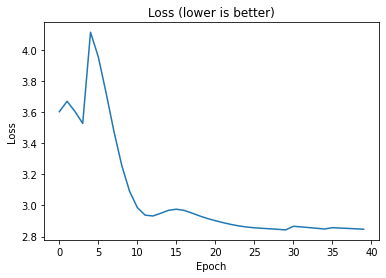

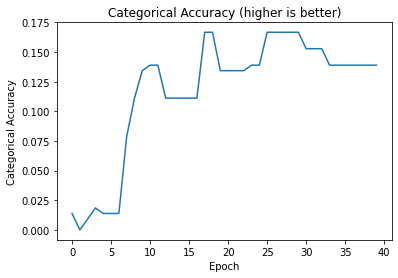

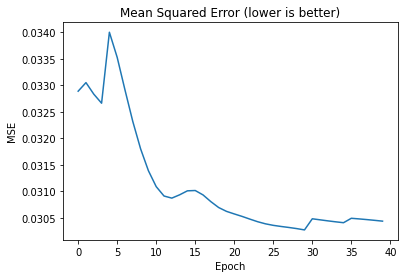

In [38]:
import matplotlib.pyplot as plt

loss = phase_1.history['loss'] + phase_2.history['loss'] + phase_3.history['loss'] 
accu = phase_1.history['categorical_accuracy'] + phase_2.history['categorical_accuracy'] \
          + phase_3.history['categorical_accuracy']
mse = phase_1.history['mean_squared_error'] + phase_2.history['mean_squared_error'] \
          + phase_3.history['mean_squared_error']


plt.plot(loss)
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(accu)
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(mse)
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

## Prediction Task and  Network Analysis
For the last phase of the simulation, we must inspect whether the model is indeed capable of predicting the last token for 12 grammatical strings. 

In [39]:
pred_block = random.sample(generate_grammatical_block(), 12)

# lets view our 12 prediction strings
print(pred_block)

[('pel', 'nilbo', 'rid'), ('vot', 'chila', 'tood'), ('dak', 'deecha', 'jic'), ('vot', 'gople', 'tood'), ('dak', 'nilbo', 'jic'), ('pel', 'wiffle', 'rid'), ('vot', 'nilbo', 'tood'), ('dak', 'suleb', 'jic'), ('pel', 'feenam', 'rid'), ('dak', 'chila', 'jic'), ('vot', 'taspu', 'tood'), ('vot', 'puser', 'tood')]


In order to know what exactly our model predicts, we will create a sequence consisting of all $12*3=36$ tokens in the prediction block and pass it to our model for inference. We use our one-hot encoder to decode the softmax model predictions back to the original token strings for inspection:

In [40]:
# convert data to one-hot vectors and make model predictions
pred_tokens = [token for tokens in pred_block for token in tokens]
pred_vectors = encoder.transform(pred_tokens)
X_pred = pred_vectors[np.newaxis, :]

# decode and inspect
predictions = encoder.inverse_transform(np.array(misyak_MODEL.predict(X_pred)[0]))

print('12-item prediction task input tokens:\n{}'.format(pred_tokens))
print('\n12-item prediction task output predictions:\n{}'.format(predictions))

12-item prediction task input tokens:
['pel', 'nilbo', 'rid', 'vot', 'chila', 'tood', 'dak', 'deecha', 'jic', 'vot', 'gople', 'tood', 'dak', 'nilbo', 'jic', 'pel', 'wiffle', 'rid', 'vot', 'nilbo', 'tood', 'dak', 'suleb', 'jic', 'pel', 'feenam', 'rid', 'dak', 'chila', 'jic', 'vot', 'taspu', 'tood', 'vot', 'puser', 'tood']

12-item prediction task output predictions:
['hiftam' 'dak' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood'
 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'dak' 'tood' 'tood'
 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'dak' 'tood' 'tood' 'tood'
 'tood' 'tood' 'tood' 'tood' 'tood' 'tood']


Inspect the predictions of the model. Is it indeed able to correctly infer the ending syllable token after seeing the starting and the middle ones? What percentage of the 12 strings were correctly classified? Is this close to your resulting accuracy in your model? You can also make use of the visualization utilities implemented for Lab 1 to inspect the state of our SRN for the Misyak et al. simulation. (Remember to copy paste the necessary python files `plot_functions.py` and `utils.py` to your current working directory)

In [43]:
from utils import *
from plot_functions import *

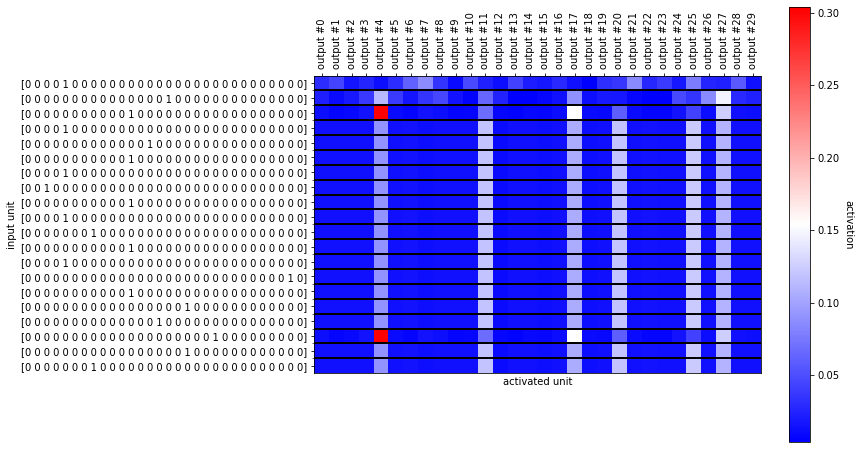

In [44]:
plt.figure(figsize=(10,8))
plot_activation_matrix(misyak_MODEL, X_gram, layers=[misyak_MODEL.layers[1]],
                       subset=(0, slice(0, 20), slice(None)),
                       show_values=False)

## Exercise 5

  A) How many weight parameters does the SRN model have in total? How many for the hidden, context and dense layers separately?
  
  ANSWER
  
The weights parameters obtained after initializing the model for Misyak et al experiment is 1,170 trainable parameters in total. The size of the input layer in 30 with 15 hidden and context units. The output or dense layer contains 30 units same as the input layer. The trainable parameters(weights, bias) obtained in the hidden layer is 465 and context layer has 225 in total whereas the weights parameters in dense layer in 480.

  B) What is the loss function that you utilize for training the model. What are the evaluation metrics? Do these numbers represent in their absolute value how well the model is able to predict the end token for each string? Explain your answer.
  
  ANSWER
  
The loss function used in the above defined model is categorical crossentropy and the performance of the model is evaluated using two metrics namely categorical accuracy and mean sqaure error.

The values of the loss represent in their absolute value how well the model is able to predict the end token for each string. Because the training involves data where the input-output relationship is one-to-one and in the training phase, the model learns what the correct category is. So, the mapping of the correct category to the input represents how well the model is able to predict.

The values of accuracy and mean square error however does not represent how well the prediction was, for each string, because, categorical accuracy is a percentage of how many values in the prediction match the actual output, which is not a true measure of how well prediction works. Since, mean squared error is proportional to accuracy, mean squared error values do not represent how well the prediction was, for each string.

  C) How does learning proceed? Include in your report information (table/plot) about the error metrics after each block and at the end of the training. Do you see the effect of the 24 ungrammatical trials in the error? How does learning in the recovery period proceed? Briefly but precisely, describe how it went.
  
  ANSWER
  
  At the end of training of grammatical block, the decrease in loss was significant. However, the ungrammatical block increased the loss due to the model facing difficulty learning the correct output category for a particular input (since there are two output categories). With each epochs passed, the model learned the correct outputs and the loss decreased (but not significantly). With the introduction of recovery block, the loss decreased again, due to the training it received during the grammatical block.

  D) In the Misyak et al. study they took the mean score after 30 runs with different random weight initilization. What was the purpose of this? (What does it simulate?)
  
  ANSWER
  
  The mean score of 30 runs were taken because averaging the score would eliminate any skewed results that were obtained since the weights were randomly initialised with uniform distribution.

  E) For the 12-item predictiont task, Misyak et al. calculated the Luce ratio difference scores to determine the network's selection. Do this calculation for the 12-item prediction task and include it in your report.
  
  ANSWER
  
  //The last cell of this subsection has the code that calculates and prints the luce ratio.

In [47]:
pred_block = random.sample(generate_grammatical_block(), 12)

print(pred_block)

[('dak', 'coomo', 'jic'), ('vot', 'deecha', 'tood'), ('vot', 'suleb', 'tood'), ('vot', 'kicey', 'tood'), ('dak', 'plizet', 'jic'), ('dak', 'hiftam', 'jic'), ('pel', 'roosa', 'rid'), ('pel', 'nilbo', 'rid'), ('dak', 'vamey', 'jic'), ('dak', 'skiger', 'jic'), ('vot', 'puser', 'tood'), ('dak', 'deecha', 'jic')]


In [49]:
pred_tokens = [token for tokens in pred_block for token in tokens]
pred_vectors = encoder.transform(pred_tokens)
X_pred = pred_vectors[np.newaxis, :]

predictions = encoder.inverse_transform(np.array(misyak_MODEL.predict(X_pred)[0]))

print('12-item prediction task input tokens:\n{}'.format(pred_tokens))
print('\n12-item prediction task output predictions:\n{}'.format(predictions))

12-item prediction task input tokens:
['dak', 'coomo', 'jic', 'vot', 'deecha', 'tood', 'vot', 'suleb', 'tood', 'vot', 'kicey', 'tood', 'dak', 'plizet', 'jic', 'dak', 'hiftam', 'jic', 'pel', 'roosa', 'rid', 'pel', 'nilbo', 'rid', 'dak', 'vamey', 'jic', 'dak', 'skiger', 'jic', 'vot', 'puser', 'tood', 'dak', 'deecha', 'jic']

12-item prediction task output predictions:
['fengle' 'vot' 'dak' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood'
 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood'
 'dak' 'tood' 'tood' 'dak' 'tood' 'tood' 'tood' 'tood' 'tood' 'tood'
 'tood' 'tood' 'tood' 'tood' 'tood' 'tood']


In [66]:
acti = get_activation_matrix2(misyak_MODEL, X_pred, layers=[misyak_MODEL.layers[1]])
acti = acti[0]
luce_ratio = []

for i in range(36):
    luce = []
    for j in acti[i]:
        ratio = j/np.sum(acti[i])
        luce.append(ratio)
    luce_ratio.append(luce)
for i in luce_ratio:
    print(i)

[0.009257981, 0.0046776105, 0.037731305, 0.017666498, 0.19142151, 0.010838413, 0.0064007267, 0.007394774, 0.0108726565, 0.014314624, 0.004750648, 0.2037053, 0.017482325, 0.016125642, 0.0075110043, 0.021663433, 0.0093453415, 0.07186277, 0.00761573, 0.008507795, 0.06902411, 0.012511464, 0.005487893, 0.015547235, 0.01069803, 0.060665295, 0.008811997, 0.0949485, 0.02692273, 0.016236683]
[0.013542408, 0.016789438, 0.0072673815, 0.01902109, 0.038498826, 0.018759137, 0.00780583, 0.014866783, 0.028894566, 0.007034586, 0.014847937, 0.13792105, 0.0056669624, 0.006107684, 0.013162989, 0.012441481, 0.0059605013, 0.10098706, 0.0186009, 0.012457085, 0.10549982, 0.02050598, 0.04674132, 0.0075264666, 0.0056071696, 0.117894776, 0.008560254, 0.16285287, 0.007783247, 0.016394394]
[0.012273092, 0.009439421, 0.026501587, 0.009159762, 0.17471813, 0.0114985285, 0.016663685, 0.010923431, 0.009328178, 0.014811726, 0.017059881, 0.08038607, 0.024463797, 0.028593423, 0.013691839, 0.01897793, 0.0069477046, 0.09710

## Part 3: Extending Misyak et al.
Now that you have recreated the simulation from the Misyak et al. paper, you are ready to extend it. What would happen if instead of one word, there were two words in the middle position? Using the same network (don't add addtional hidden layers!) create new training data that differ from the original by having two words in the middle position. Run the new simulation.

## Exercise 6

 A) How does learning proceed now? Describe learning, how the error metrics develop (especially after blocks 6,7 and 8).
 
 ANSWER
 
 Looking the accuracy graph, it can be said that the performance of the model was significantly poorer compared to the actual model (1 middle word). Introduction of ungrammatical block reduced the accuracy at first and through epochs had a minor improvement, similar to the effect it had in the actual model (1 middle word). 
 
 However, the recovery block which improved the accuracy in the actual model (1 middle word), had an ironic effect and reduced the acccuracy. Through epochs, it slowly improved the accuracy back to the accuracy the model had at the end of ungrammatical block.a

In [50]:
def grammatical_block_2words():
    return [(*r, grammar_map[r[0]]) for r in itertools.product(start_tokens, middle_tokens, middle_tokens)]

def ungrammatical_block_2words():
    ung = []
    alt = 0
    for r in itertools.product(start_tokens, middle_tokens, middle_tokens):
        if alt == 0:
            temp = (*r, non_grammar_map[r[0]][0])
            alt = 1
        elif alt == 1:
            temp = (*r, non_grammar_map[r[0]][1])
            alt = 0
        ung.append(temp)
    ung_block = ung[0:192] + ung[768:960] + ung[1536:1728]
    return ung_block

print(grammatical_block_2words())
print(ungrammatical_block_2words())

[('pel', 'wadim', 'wadim', 'rid'), ('pel', 'wadim', 'kicey', 'rid'), ('pel', 'wadim', 'puser', 'rid'), ('pel', 'wadim', 'fengle', 'rid'), ('pel', 'wadim', 'coomo', 'rid'), ('pel', 'wadim', 'loga', 'rid'), ('pel', 'wadim', 'gople', 'rid'), ('pel', 'wadim', 'taspu', 'rid'), ('pel', 'wadim', 'hiftam', 'rid'), ('pel', 'wadim', 'deecha', 'rid'), ('pel', 'wadim', 'vamey', 'rid'), ('pel', 'wadim', 'skiger', 'rid'), ('pel', 'wadim', 'benez', 'rid'), ('pel', 'wadim', 'gensim', 'rid'), ('pel', 'wadim', 'feenam', 'rid'), ('pel', 'wadim', 'laelijeen', 'rid'), ('pel', 'wadim', 'chila', 'rid'), ('pel', 'wadim', 'roosa', 'rid'), ('pel', 'wadim', 'plizet', 'rid'), ('pel', 'wadim', 'balip', 'rid'), ('pel', 'wadim', 'malsig', 'rid'), ('pel', 'wadim', 'suleb', 'rid'), ('pel', 'wadim', 'nilbo', 'rid'), ('pel', 'wadim', 'wiffle', 'rid'), ('pel', 'kicey', 'wadim', 'rid'), ('pel', 'kicey', 'kicey', 'rid'), ('pel', 'kicey', 'puser', 'rid'), ('pel', 'kicey', 'fengle', 'rid'), ('pel', 'kicey', 'coomo', 'rid'), 

In [51]:
e_gram_block = random.sample(grammatical_block_2words(), 1728)
e_ungr_block = random.sample(ungrammatical_block_2words(), 576)
e_rec_block = random.sample(grammatical_block_2words(), 1728)

encoder = LabelBinarizer()
encoder.fit(all_tokens)

e_gram_tokens = [token for tokens in e_gram_block for token in tokens]
e_ungr_tokens = [token for tokens in e_ungr_block for token in tokens]
e_rec_tokens = [token for tokens in e_rec_block for token in tokens]

e_gram_vectors = encoder.transform(e_gram_tokens)
e_ungr_vectors = encoder.transform(e_ungr_tokens)
e_rec_vectors = encoder.transform(e_rec_tokens)

X_gram_e = e_gram_vectors[np.newaxis, :]
y_gram_e = np.append(e_gram_vectors[1:], e_gram_vectors[:1], axis=0)[np.newaxis, :]

X_ungr_e = e_ungr_vectors[np.newaxis, :]
y_ungr_e = np.append(e_ungr_vectors[1:], e_ungr_vectors[:1], axis=0)[np.newaxis, :]

X_rec_e = e_rec_vectors[np.newaxis, :]
y_rec_e = np.append(e_rec_vectors[1:], e_rec_vectors[:1], axis=0)[np.newaxis, :]

print(X_gram_e.shape, y_gram_e.shape, X_ungr_e.shape, y_ungr_e.shape, X_rec_e.shape, y_rec_e.shape)

(1, 6912, 30) (1, 6912, 30) (1, 2304, 30) (1, 2304, 30) (1, 6912, 30) (1, 6912, 30)


In [52]:
scale_factor = 5
model_loss, model_acc, model_mse = [], [], []

for i in range(30):
    misyak_MODEL = Create_misyak_model()
    
    print('Model: ', i)
    
    print('-'*100)
    
    
    print('Phase 1: 6 grammatical blocks of 72 strings..\n')
    phase_1 = misyak_MODEL.fit(X_gram, y_gram, epochs=6*scale_factor, verbose=0)
    phase_1_loss = phase_1.history['loss']
    phase_1_acc = phase_1.history['categorical_accuracy']
    phase_1_mse = phase_1.history['mean_squared_error']
    print('-'*100)

    print('Phase 2: 1 ungrammatical block of 24 strings..\n') 
    phase_2 = misyak_MODEL.fit(X_ungr, y_ungr, epochs=1*scale_factor, verbose=0)
    phase_2_loss = phase_2.history['loss']
    phase_2_acc = phase_2.history['categorical_accuracy']
    phase_2_mse = phase_2.history['mean_squared_error']
    print('-'*100)

    print('Phase 3: 1 recovery block of 72 strings..\n')
    phase_3 = misyak_MODEL.fit(X_rec, y_rec, epochs=1*scale_factor, verbose=0)
    phase_3_loss = phase_3.history['loss']
    phase_3_acc = phase_3.history['categorical_accuracy']
    phase_3_mse = phase_3.history['mean_squared_error']
    print('-'*100)
    

    model_loss.append(phase_1_loss + phase_2_loss + phase_3_loss)
    model_acc.append(phase_1_acc + phase_2_acc + phase_3_acc)
    model_mse.append(phase_1_mse + phase_2_mse + phase_3_mse)
print(misyak_MODEL.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
Model:  0
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------

 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
Model:  6
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
____________________________________________________________

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)          (None, None, 8)           232       
                                                                 
 time_distributed (TimeDistr  (None, None, 20)         180       
 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
Model:  19
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

-----------------------------------------------------------------------------------------------

 ibuted)                                                         
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________
None
Model:  25
----------------------------------------------------------------------------------------------------
Phase 1: 6 grammatical blocks of 72 strings..

----------------------------------------------------------------------------------------------------
Phase 2: 1 ungrammatical block of 24 strings..

----------------------------------------------------------------------------------------------------
Phase 3: 1 recovery block of 72 strings..

----------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (SimpleRNN)         

In [53]:
model_loss

[[3.635065793991089,
  3.7013607025146484,
  3.553133249282837,
  3.923898220062256,
  3.746746778488159,
  3.499074935913086,
  3.3908956050872803,
  3.3228800296783447,
  3.1945993900299072,
  3.1477773189544678,
  3.0963850021362305,
  3.0752573013305664,
  3.0638301372528076,
  3.048407554626465,
  3.0298428535461426,
  3.0065183639526367,
  2.9847869873046875,
  2.9790213108062744,
  2.962000608444214,
  2.948845863342285,
  2.9356648921966553,
  2.921276807785034,
  2.905662775039673,
  2.8902339935302734,
  2.8755946159362793,
  2.8623783588409424,
  2.8505568504333496,
  2.840282917022705,
  2.8298611640930176,
  2.8201186656951904,
  3.124180793762207,
  3.090768575668335,
  3.0906143188476562,
  3.045705556869507,
  2.999393939971924,
  2.967381477355957,
  2.965054512023926,
  2.953580856323242,
  2.9352707862854004,
  2.9138386249542236],
 [3.639091968536377,
  3.606210231781006,
  3.5195484161376953,
  3.3904266357421875,
  3.2514359951019287,
  3.127803087234497,
  3.0335

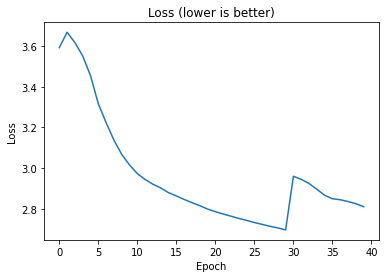

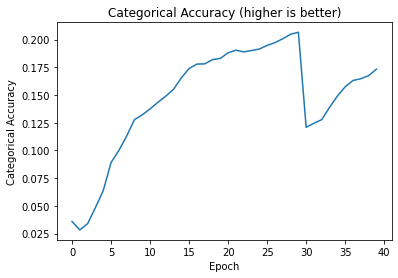

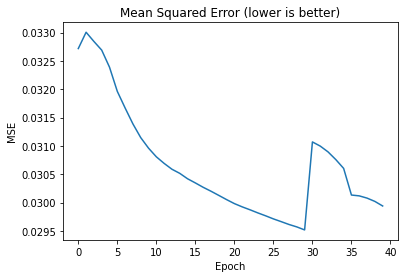

In [54]:
final_loss, final_acc, final_mse = [], [], []
for i in range(40):
    _loss, _acc, _mse = 0, 0, 0
    for j in range(30):
        _loss += model_loss[j][i]
        _acc += model_acc[j][i]
        _mse += model_mse[j][i]
    final_loss.append(_loss/30)
    final_acc.append(_acc/30)
    final_mse.append(_mse/30)

plt.plot(final_loss)
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(final_acc)
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(final_mse)
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

 B) Compare the prediction capacity of the model in this extended simulation to the one of the previous section, commenting on similarities and differences.
 
  ANSWER
  
  The prediction capacity of the model is severely damaged compared the actual model (1 middle word). During training, the accuracy in the actual model was 20%. The final accuracy was really low as well. The similarity of the two models is that the grammatical blocks improved accuracy (ignoring the rate of improvement) and introduction of the ungrammatical block lead to fall in the accuracy (possibly of different magnitudes, but nevertheless, decreased the accuracy). After prediction block, it was concluded that the predcition capacity of the model was completely damaged, and was predicting the same value for different inputs.

In [56]:
pred_block = random.sample(grammatical_block_2words(), 12)

pred_tokens = [token for tokens in pred_block for token in tokens]
pred_vectors = encoder.transform(pred_tokens)
X_pred = pred_vectors[np.newaxis, :]

predictions = encoder.inverse_transform(np.array(misyak_MODEL.predict(X_pred)[0]))

print('12-item prediction task input tokens:\n{}'.format(pred_tokens))
print('\n12-item prediction task output predictions:\n{}'.format(predictions))

12-item prediction task input tokens:
['dak', 'chila', 'hiftam', 'jic', 'dak', 'feenam', 'plizet', 'jic', 'dak', 'vamey', 'kicey', 'jic', 'pel', 'puser', 'gensim', 'rid', 'dak', 'feenam', 'gople', 'jic', 'dak', 'fengle', 'gensim', 'jic', 'pel', 'puser', 'deecha', 'rid', 'vot', 'wiffle', 'gople', 'tood', 'pel', 'chila', 'fengle', 'rid', 'vot', 'benez', 'loga', 'tood', 'dak', 'wadim', 'malsig', 'jic', 'vot', 'wiffle', 'loga', 'tood']

12-item prediction task output predictions:
['jic' 'vot' 'dak' 'vot' 'jic' 'vot' 'dak' 'vot' 'jic' 'vot' 'dak' 'vot'
 'dak' 'vot' 'dak' 'vot' 'jic' 'vot' 'dak' 'vot' 'jic' 'vot' 'dak' 'vot'
 'dak' 'vot' 'dak' 'vot' 'dak' 'vot' 'dak' 'vot' 'dak' 'vot' 'dak' 'vot'
 'dak' 'vot' 'dak' 'vot' 'jic' 'vot' 'jic' 'pel' 'jic' 'tood' 'jic' 'vot']


 C) SRNs with only one context layer can learn more than just one step back in time. But is your SRN successful in this task? Explain your answer.
 
 ANSWER
 
 The model failed in this task, as if it had learned more than one step back in time, the accuracy would have been on the same scale as the actual model (1 middle word), and would not have collapsed.


 D) What do you predict human subjects will do, based on the results of your simulation?
 
ANSWER

Human subjects are not good at learning ungrammatic blocks and trying to learn the ungrammatic block might hinder the learning that human subjects already had.